## 2D Inference

The following cells present basic 2D (single image) inference with OTAS. The use OTAS Small for 2D semantic segmentation. Batch inference is also supported for 2D segmentation using `single_inference.similarity_batch()` and `single_inference.segmentation_batch()`.

The example image is from the RELLIS-3D dataset [(link)](https://github.com/unmannedlab/RELLIS-3D).

### Similarity

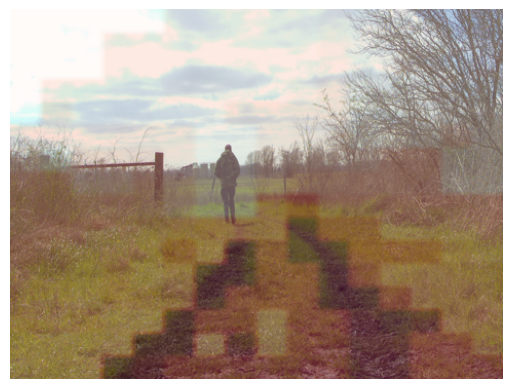

In [ ]:
import sys; sys.path.append("src") # Tested in Docker container. Change path to OTAS src folder
from inference import single_inference

from PIL import Image # For visualisation and image loading
import matplotlib.pyplot as plt
import numpy as np


## Model params can be overwritten as arguments. See config.py for available params.
model = single_inference(
    enable_mask_refinement=False,
    n_components=48,
    n_clusters=24,
    shared_feat_resolution=64,
    dino_scale_factor=1
)

img_path = "/eval_data/Rellis-3D/00000/pylon_camera_node/frame000218-1581624674_550.jpg"
img = Image.open(img_path).convert("RGB").resize((480,360))

res = model.similarity_single(img, pos_prompts=["dirt path"], neg_prompts=["thing"])

plt.imshow(img)
plt.imshow(res, cmap="Reds", alpha=0.35)
plt.axis("off")
plt.show()

### Segmentation

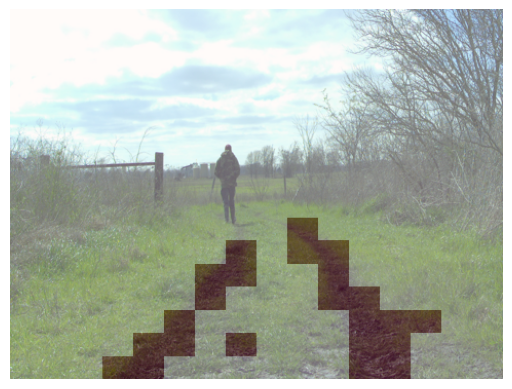

In [22]:
res = model.segmentation_single(img, pos_prompts=["dirt path"], neg_prompts=["thing"], threshold_value=0.8)
plt.imshow(img)
plt.imshow(res, cmap="Reds", alpha=0.35)
plt.axis("off")
plt.show()

### With Mask Refinement (for fine-grained classes)

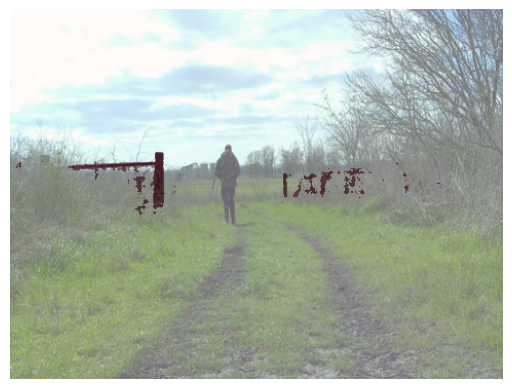

In [29]:
model = single_inference(
    enable_mask_refinement=True,
    n_components=48,
    n_clusters=24,
    shared_feat_resolution=64,
    dino_scale_factor=1
)

res = model.segmentation_single(img, pos_prompts=["wooden fence"], neg_prompts=["thing"])
plt.imshow(img)
plt.imshow(res, cmap="Reds", alpha=0.35)
plt.axis("off")
plt.show()

---

## OTAS Spatial Inference

Spatial inference requires intrinsic calibration, camera poses and metric depth maps for reconstruction. If not available, inference can be performed with just RGB images using VGGT for internal/external calibration and relative depth and Zoedepth for metric depth.

Alternatively, `inference.py` has helper functions to export to/imoprt from nerfstudio datasets. For imports, the Nerfstudio dataset must include depth images, as specified in the Nerfstudio data conventions [(link)](https://docs.nerf.studio/quickstart/data_conventions.html).

The following cells present a small demo reconstructing a hiking path in the alps from phone photos.

<img src="./img/demo/dataset_demo.png" alt="Example Image from Dataset" width="250">

In [ ]:
import sys; sys.path.append("src") # Tested in Docker container. Change path to OTAS repository root
from inference import spatial_inference, all_imgs_in_dir

img_paths = all_imgs_in_dir("img/outdoor_reconstruction")

# Similarly to the 2D pipeline, model parameters can be passed as keyword arguments to the constructor
model = spatial_inference(vggt_image_paths = img_paths, # Initialise just from images using VGGT. 
                         voxel_size = 0.2)

# model = spatial_inference(ns_data_path = "path_to_nerfstudio_dataset") # Alternative: Point to Nerfstudio dataset directory

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[OTAS]: Using custom config from: /src/model_config/OTAS_spatial.json
[OTAS]: Dinov2 pipeline instantiated
[OTAS]: MaskCLIP pipeline instantiated
[OTAS]: Camera calibration pipeline instantiated
[OTAS]: No depth or camera poses provided, estimating from VGGT


/src/inference.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):
/src/foundation_models/vggt/vggt/models/vggt.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


[OTAS]: Masking sky for depth estimation


[OTAS]: Segmentation Batch: 100%|██████████| 10/10 [00:00<00:00, 16.32it/s]


[OTAS]: Scaling depths to metric depth


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0
[OTAS]: Semantic Embedding and 3D Projection: 100%|██████████| 10/10 [00:00<00:00, 71.57it/s]
[OTAS]: Backprojecting and pooling embeddings per frame: 100%|██████████| 10/10 [00:00<00:00, 297.55it/s]
[OTAS]: Performing Voxelisation: 100%|██████████| 4898/4898 [00:00<00:00, 46906.96it/s]


When passing a Nerfstudio dataset or initialising from VGGT, reconstruction will immediately be performed. The `model` object can then be masked from semantic similarity or have semantics visualised using PCA.

The following cell loads and cleans up the geometric reconstruction. 

In [ ]:
import open3d as o3d

pcd = model.cleanup_overexposed_pcd(model.pcd_colour)
pcd = model.cleanup_geometric_pcd(pcd)

o3d.io.write_point_cloud("./otas_reconstruction_geometric.ply", pcd)

The following cell visualises the OTAS language embedding in the reconstruction using PCA.

In [2]:
pcd = model.visualise_pca_pcd()

o3d.io.write_point_cloud("./otas_reconstruction_pca.ply", pcd)

[Open3D WARNING] Write Ply clamped color value to valid range


True

Here are the geometric reconstruction and PCA over language embeddings side by side.

<img src="./img/demo/otas_spatial_demo_colour.png" alt="Geometric Reconstruction Demo" width="500"><img src="./img/demo/otas_spatial_demo_pca.png" alt="PCA over Semantics Demo" width="500">

Semantic similarity can also be directly visualised using a colourmap.

In [3]:
pcd = model.query_relevance_pcd(["wooden bridge"], ["object"])
pcd = model.cleanup_geometric_pcd(pcd)

o3d.io.write_point_cloud("./otas_reconstruction_similarity.ply", pcd)

True

The following plot shows a PCA reconstruction, semantic similarity to _**wooden bridge**_ (seen at the beginning of the example images) alongside the geometric reconstruction.

<img src="./img/demo/otas_spatial_demo_colour.png" alt="Geometric Reconstruction Demo" width="500"><img src="./img/demo/otas_spatial_demo_similarity.png" alt="Similarity to Prompt Demo" width="500">